In [1]:
from preamble import *

In [4]:
data = pd.read_csv('./data/j_weather_data_v2.csv')
# data = data.drop('snow', axis=1)
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.rename(columns={
    'outflow': 'inflow', 
    'input':'outflow'
  })
data['outflow'] = data['outflow'] / 60
data['inflow'] = data['inflow'] / 60
print(type(data), data.shape)
data.head()

<class 'pandas.core.frame.DataFrame'> (15739, 9)


,datetime,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,snow,inflow,outflow
0,2023-01-01 00:00:00,-0.9,0.0,1.4,72.0,1023.6,0.0,77.88,101.05
1,2023-01-01 01:00:00,-1.3,0.0,1.5,74.0,1023.3,0.0,107.09,119.92
2,2023-01-01 02:00:00,-1.7,0.0,1.4,75.0,1023.1,0.0,143.67,124.54
3,2023-01-01 03:00:00,-2.0,0.0,1.2,77.0,1023.3,0.0,144.95,80.16
4,2023-01-01 04:00:00,-2.0,0.0,1.7,79.0,1022.8,0.0,159.06,104.88


In [5]:
data.loc[data['outflow'] <= 1, 'outflow'] = np.nan
median_value = data['outflow'].median()
data['outflow'] = data['outflow'].fillna(median_value)

In [6]:
target_variable = 'outflow'

data_temp = data.copy()
data_temp['outflow_diff'] = data_temp[target_variable].diff().abs()
limit = 0.001 # df_temp['outflow_diff'][2019] = 0.0014899999996487168

flat_regions = []
start_index = None
for i, diff in enumerate(data_temp['outflow_diff']):
  if diff <= limit:
    if start_index is None:
      start_index = i
  elif start_index is not None:
    flat_regions.append((start_index, i - 1))
    start_index = None

# 마지막 구간 처리
if start_index is not None:
  flat_regions.append((start_index, len(df) -1))

# threshold = data_temp['outflow_diff'].mean() + 1.5 * data_temp['outflow_diff'].std()
threshold = data_temp['outflow_diff'].mean() + 2 * data_temp['outflow_diff'].std()
anomaly_indices = data_temp[data_temp['outflow_diff'] > threshold].index.tolist()

data_dropped = data_temp.drop(index=range(12303, 12515)).reset_index(drop=True)
data_replace = data_dropped.drop('outflow_diff', axis=1)
for index in anomaly_indices:
  if index > 0 and index < len(data_replace) :
    data_replace.loc[index, target_variable] = data_replace.loc[index-1, target_variable]
  elif index == 0 and len(data_replace) > 1:
    data_replace.loc[index, target_variable] = data_replace.loc[index+1, target_variable]
data_cleaned = data_replace.copy()
print(f"Shape of data after replacing outliers : {data_cleaned.shape}")

Shape of data after replacing outliers : (15527, 9)


In [7]:
import holidays

kr_holidays = holidays.KR()
data_cleaned['is_weekend'] = data_cleaned['datetime'].dt.dayofweek >= 5 | data_cleaned['datetime'].isin(kr_holidays)
data_cleaned.head()

,datetime,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,snow,inflow,outflow,is_weekend
0,2023-01-01 00:00:00,-0.9,0.0,1.4,72.0,1023.6,0.0,77.88,101.05,True
1,2023-01-01 01:00:00,-1.3,0.0,1.5,74.0,1023.3,0.0,107.09,119.92,True
2,2023-01-01 02:00:00,-1.7,0.0,1.4,75.0,1023.1,0.0,143.67,124.54,True
3,2023-01-01 03:00:00,-2.0,0.0,1.2,77.0,1023.3,0.0,144.95,80.16,True
4,2023-01-01 04:00:00,-2.0,0.0,1.7,79.0,1022.8,0.0,159.06,104.88,True


In [8]:
def create_time_feature(df): 
  df['dayofmonth'] = df['datetime'].dt.day 
  df['dayofweek'] = df['datetime'].dt.dayofweek 
  df['quarter'] = df['datetime'].dt.quarter 
  df['month'] = df['datetime'].dt.month 
  df['year'] = df['datetime'].dt.year 
  df['dayofyear'] = df['datetime'].dt.dayofyear 
  df['week'] = df['datetime'].dt.isocalendar().week
  df['hour'] = df['datetime'].dt.hour
  df['minute'] = df['datetime'].dt.minute
  df['second'] = df['datetime'].dt.second
  return df

In [9]:
df = create_time_feature(data_cleaned)

In [10]:
df.head()

,datetime,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,snow,inflow,outflow,is_weekend,dayofmonth,dayofweek,quarter,month,year,dayofyear,week,hour,minute,second
0,2023-01-01 00:00:00,-0.9,0.0,1.4,72.0,1023.6,0.0,77.88,101.05,True,1,6,1,1,2023,1,52,0,0,0
1,2023-01-01 01:00:00,-1.3,0.0,1.5,74.0,1023.3,0.0,107.09,119.92,True,1,6,1,1,2023,1,52,1,0,0
2,2023-01-01 02:00:00,-1.7,0.0,1.4,75.0,1023.1,0.0,143.67,124.54,True,1,6,1,1,2023,1,52,2,0,0
3,2023-01-01 03:00:00,-2.0,0.0,1.2,77.0,1023.3,0.0,144.95,80.16,True,1,6,1,1,2023,1,52,3,0,0
4,2023-01-01 04:00:00,-2.0,0.0,1.7,79.0,1022.8,0.0,159.06,104.88,True,1,6,1,1,2023,1,52,4,0,0


In [11]:
df.dropna(inplace=True)

In [12]:
df.to_csv(path_or_buf='data/j_weather_data_v4.csv', index=False)

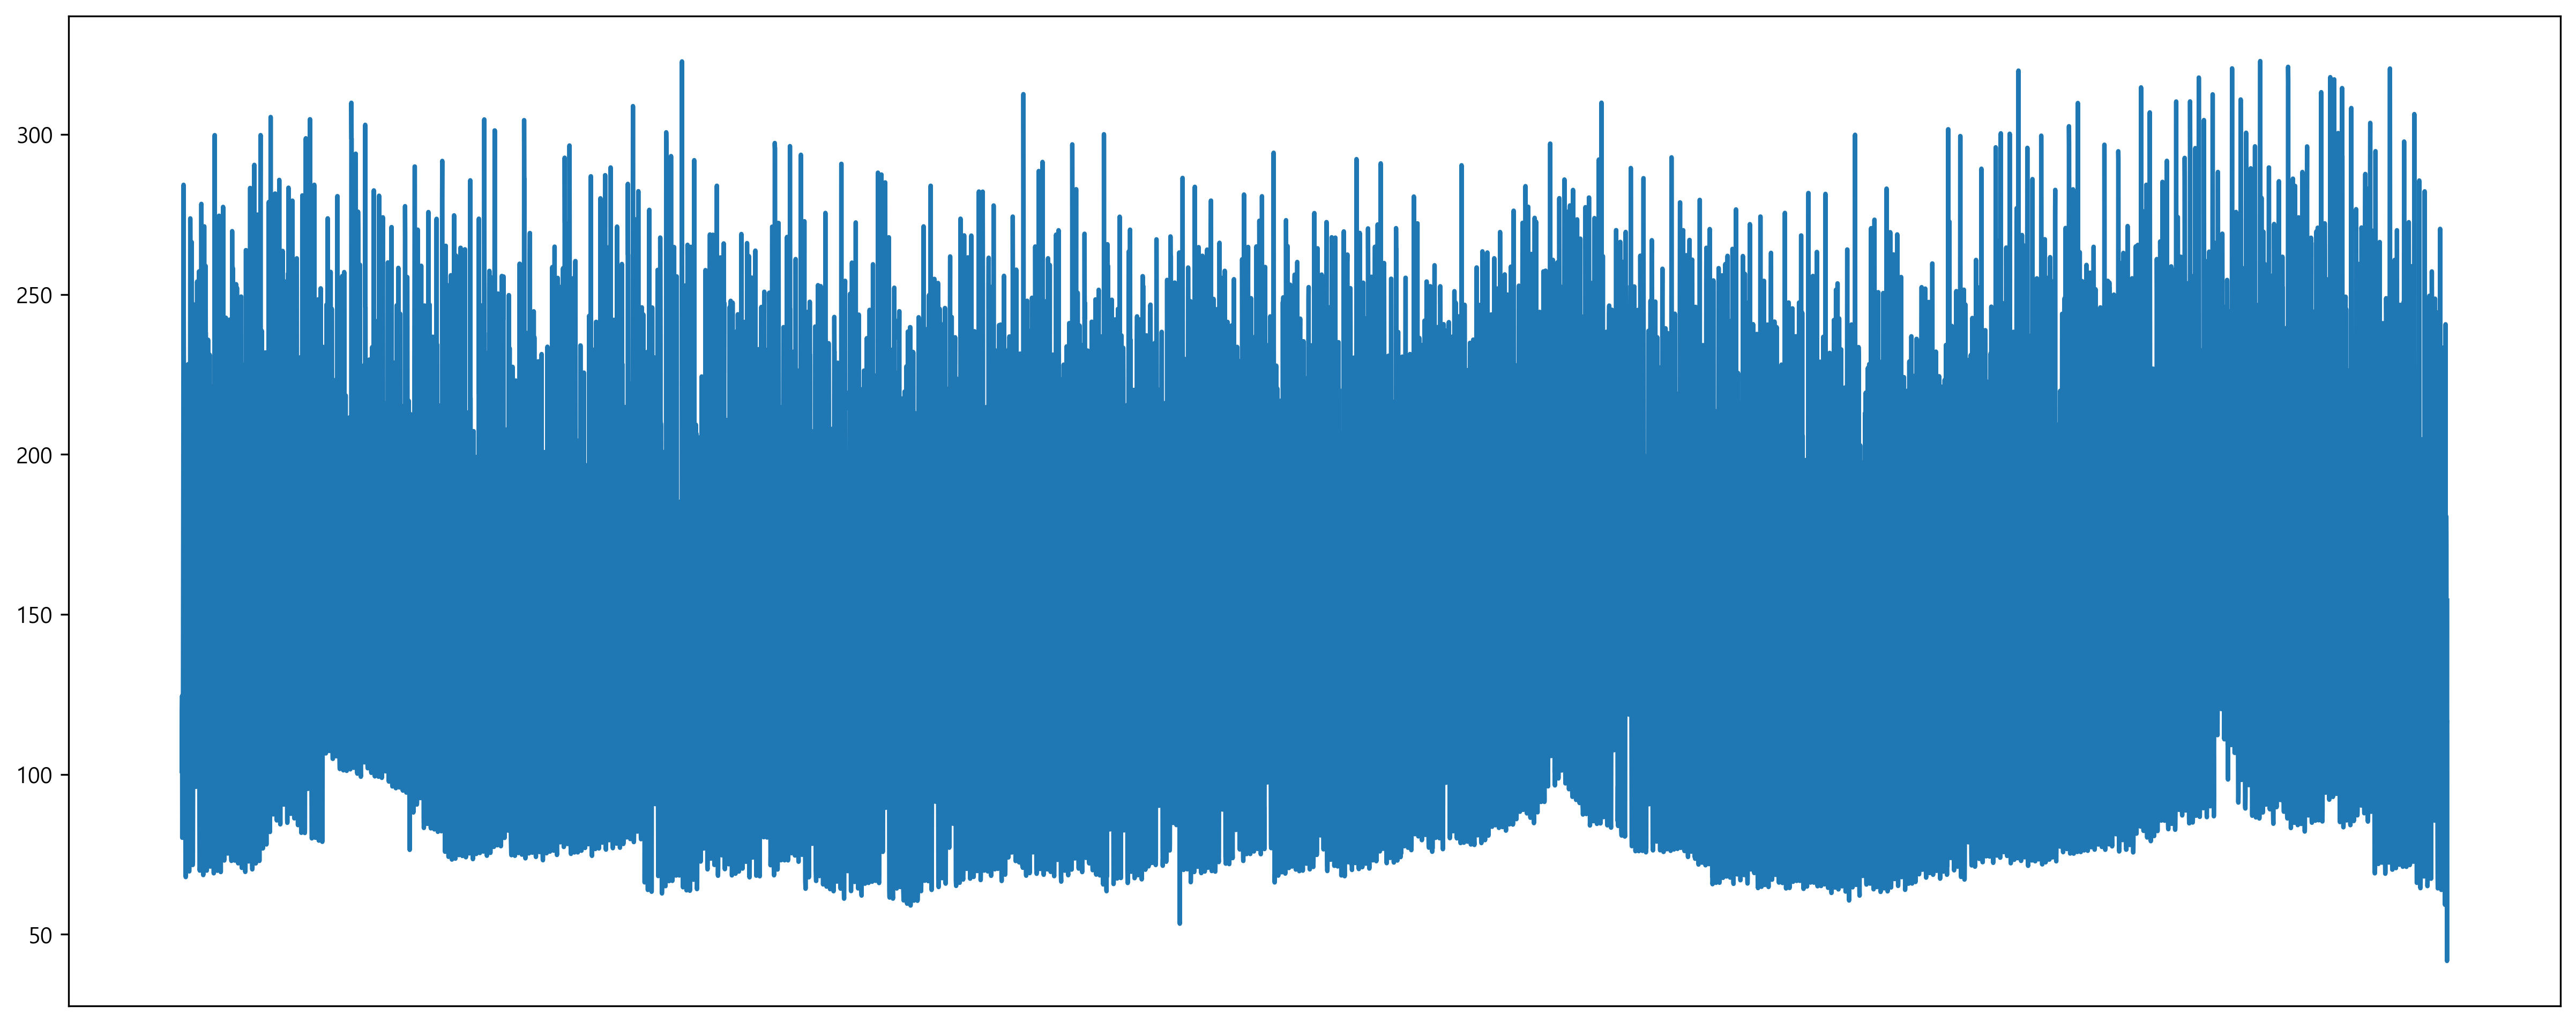

In [13]:
plt.figure(figsize=(20, 8))
plt.xticks([])  # x축 눈금 제거
plt.plot(df.index, df['outflow'], label='Cleaned Data')
plt.show()

In [14]:
start_date = pd.to_datetime('2023-09-01')  # 시작 날짜 (2023년 10월 1일)
end_date = pd.to_datetime('2023-11-01')  # 종료 날짜 (2023년 11월 1일)

data_oct = df.loc[(df['datetime'] > start_date) & (df['datetime'] < end_date)]
data_oct.head()

,datetime,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,snow,inflow,outflow,is_weekend,dayofmonth,dayofweek,quarter,month,year,dayofyear,week,hour,minute,second
5833,2023-09-01 01:00:00,21.1,0.0,0.2,88.0,1004.5,0.0,76.27,75.61,True,1,4,3,9,2023,244,35,1,0,0
5834,2023-09-01 02:00:00,20.1,0.0,1.0,91.0,1004.2,0.0,48.79,77.02,True,1,4,3,9,2023,244,35,2,0,0
5835,2023-09-01 03:00:00,20.9,0.0,0.3,90.0,1003.9,0.0,48.93,125.19,True,1,4,3,9,2023,244,35,3,0,0
5836,2023-09-01 04:00:00,19.6,0.0,0.7,94.0,1004.3,0.0,98.79,85.01,True,1,4,3,9,2023,244,35,4,0,0
5837,2023-09-01 05:00:00,19.1,0.0,1.3,94.0,1004.7,0.0,155.73,130.97,True,1,4,3,9,2023,244,35,5,0,0


In [13]:
data_oct.shape

(1463, 20)

In [15]:
data_oct.to_csv(path_or_buf='data/j_weather_data_October_v4.csv', index=False)